<a href="https://colab.research.google.com/github/SyaidFarhan/Project_Kuliah_Syaid/blob/main/Analisis_Sentimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

-rw-r--r-- 1 root root 68 Jun  4 04:31 kaggle.json
/content


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
rakeshkapilavai/extrovert-vs-introvert-behavior-data              Extrovert vs. Introvert Behavior Data                    15392  2025-05-21 04:26:52.443000           5824        141  1.0              
adilshamim8/social-media-addiction-vs-relationships               Students' Social Media Addiction                          7851  2025-05-10 14:38:02.713000          10974        164  1.0              
bismasajjad/global-ai-job-market-and-salary-trends-2025           Global AI Job Market & Salary Trends 2025               529004  2025-06-01 07:20:49.537000           1446         24  0.941176

In [ ]:
!kaggle datasets download -d syedmarslanalvi/x-dataset -p /content/gdrive/MyDrive/dataset


Dataset URL: https://www.kaggle.com/datasets/syedmarslanalvi/x-dataset
License(s): unknown
x-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/gdrive/MyDrive/dataset/x-dataset.zip" -d "/content/gdrive/MyDrive/dataset/x-dataset/"

Archive:  /content/gdrive/MyDrive/dataset/x-dataset.zip
replace /content/gdrive/MyDrive/dataset/x-dataset/dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!pip install nltk

In [ ]:
# Download NLTK data
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)

True

In [ ]:
# Enhanced Twitter Sentiment Analysis with Database Storage, Topic Modeling & Advanced Visualizations
import pandas as pd
import numpy as np
import sqlite3
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# =============================================================================
# 1. DATABASE SETUP AND MANAGEMENT
# =============================================================================
class TwitterDataManager:
    def __init__(self, db_path='twitter_sentiment.db'):
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)
        self.create_tables()

    def create_tables(self):
        """Create database tables for storing analysis results"""
        cursor = self.conn.cursor()

        # Main tweets table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS tweets (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                tweet_id TEXT,
                date TEXT,
                user TEXT,
                original_text TEXT,
                cleaned_text TEXT,
                sentiment_label INTEGER,
                predicted_sentiment TEXT,
                confidence_score REAL,
                word_count INTEGER,
                char_count INTEGER,
                hour INTEGER,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        # Topics table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS topics (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                topic_number INTEGER,
                topic_words TEXT,
                topic_weight REAL,
                method TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        # Tweet topics relationship
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS tweet_topics (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                tweet_id INTEGER,
                topic_id INTEGER,
                probability REAL,
                FOREIGN KEY (tweet_id) REFERENCES tweets (id),
                FOREIGN KEY (topic_id) REFERENCES topics (id)
            )
        ''')

        # Analysis results table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS analysis_results (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                analysis_type TEXT,
                result_data TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        self.conn.commit()

    def insert_tweets(self, df):
        """Insert processed tweets into database"""
        df.to_sql('tweets', self.conn, if_exists='append', index=False)
        self.conn.commit()

    def insert_topics(self, topics_data, method='LDA'):
        """Insert topic modeling results"""
        cursor = self.conn.cursor()
        for i, topic in enumerate(topics_data):
            cursor.execute('''
                INSERT INTO topics (topic_number, topic_words, topic_weight, method)
                VALUES (?, ?, ?, ?)
            ''', (i, ', '.join(topic), 1.0, method))
        self.conn.commit()

    def get_tweets(self, limit=None):
        """Retrieve tweets from database"""
        query = "SELECT * FROM tweets"
        if limit:
            query += f" LIMIT {limit}"
        return pd.read_sql_query(query, self.conn)

    def close(self):
        """Close database connection"""
        self.conn.close()


In [ ]:
# =============================================================================
# 2. ENHANCED TEXT PREPROCESSING
# =============================================================================

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        # Add custom stopwords
        custom_stopwords = {"im", "dont", "cant", "couldnt", "wouldnt", "youre", "ive", "u", "ur", "id", "wont", "rt", "amp"}
        self.stop_words.update(custom_stopwords)
        self.sia = SentimentIntensityAnalyzer()

    def clean_text(self, text):
        """Enhanced text cleaning function"""
        if pd.isna(text):
            return ""

        text = str(text).lower()
        # Remove URLs, mentions, hashtags
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenization and lemmatization
        tokens = word_tokenize(text)
        cleaned_tokens = [
            self.lemmatizer.lemmatize(word)
            for word in tokens
            if word not in self.stop_words and len(word) > 2
        ]

        return ' '.join(cleaned_tokens)

    def get_sentiment_scores(self, text):
        """Get detailed sentiment scores"""
        if pd.isna(text) or text == "":
            return {'compound': 0, 'pos': 0, 'neu': 1, 'neg': 0}

        scores = self.sia.polarity_scores(text)
        return scores

    def classify_sentiment(self, compound_score):
        """Classify sentiment based on compound score"""
        if compound_score >= 0.05:
            return "Positive"
        elif compound_score <= -0.05:
            return "Negative"
        else:
            return "Neutral"

In [ ]:
# =============================================================================
# 3. TOPIC MODELING
# =============================================================================

class TopicModeler:
    def __init__(self, n_topics=5):
        self.n_topics = n_topics
        self.lda_model = None
        self.nmf_model = None
        self.vectorizer = None
        self.topics_lda = None
        self.topics_nmf = None

    def fit_lda(self, texts):
        """Fit LDA topic model"""
        # Vectorize texts
        self.vectorizer = CountVectorizer(
            max_features=1000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )

        text_vectorized = self.vectorizer.fit_transform(texts)

        # Fit LDA
        self.lda_model = LatentDirichletAllocation(
            n_components=self.n_topics,
            random_state=42,
            max_iter=10
        )
        self.lda_model.fit(text_vectorized)

        # Get topics
        feature_names = self.vectorizer.get_feature_names_out()
        self.topics_lda = []

        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-10:]]
            self.topics_lda.append(top_words)

        return self.topics_lda

    def fit_nmf(self, texts):
        """Fit NMF topic model"""
        # Use TF-IDF for NMF
        tfidf_vectorizer = TfidfVectorizer(
            max_features=1000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )

        tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

        # Fit NMF
        self.nmf_model = NMF(
            n_components=self.n_topics,
            random_state=42,
            max_iter=100
        )
        self.nmf_model.fit(tfidf_matrix)

        # Get topics
        feature_names = tfidf_vectorizer.get_feature_names_out()
        self.topics_nmf = []

        for topic_idx, topic in enumerate(self.nmf_model.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-10:]]
            self.topics_nmf.append(top_words)

        return self.topics_nmf

    def get_topic_distribution(self, texts):
        """Get topic distribution for texts"""
        if self.lda_model is None:
            raise ValueError("LDA model not fitted yet!")

        text_vectorized = self.vectorizer.transform(texts)
        topic_distributions = self.lda_model.transform(text_vectorized)
        return topic_distributions


In [ ]:
# =============================================================================
# 4. ADVANCED VISUALIZATIONS
# =============================================================================
import seaborn as sns

class AdvancedVisualizer:
    def __init__(self):
        self.colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
        plt.style.use('seaborn-v0_8')

    def plot_sentiment_distribution_advanced(self, df):
        """Advanced sentiment distribution with statistics"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Basic count plot
        sns.countplot(data=df, x='predicted_sentiment', ax=axes[0,0], palette=self.colors)
        axes[0,0].set_title('Sentiment Distribution')
        axes[0,0].set_xlabel('Sentiment')
        axes[0,0].set_ylabel('Count')

        # 2. Pie chart
        sentiment_counts = df['predicted_sentiment'].value_counts()
        axes[0,1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=self.colors)
        axes[0,1].set_title('Sentiment Distribution (Percentage)')

        # 3. Sentiment by hour
        sentiment_hourly = df.groupby(['hour', 'predicted_sentiment']).size().unstack(fill_value=0)
        sentiment_hourly.plot(kind='bar', ax=axes[1,0], color=self.colors[:3])
        axes[1,0].set_title('Sentiment Distribution by Hour')
        axes[1,0].set_xlabel('Hour')
        axes[1,0].set_ylabel('Count')
        axes[1,0].legend(title='Sentiment')

        # 4. Confidence scores
        if 'confidence_score' in df.columns:
            sns.boxplot(data=df, x='predicted_sentiment', y='confidence_score', ax=axes[1,1], palette=self.colors)
            axes[1,1].set_title('Confidence Scores by Sentiment')
            axes[1,1].set_xlabel('Sentiment')
            axes[1,1].set_ylabel('Confidence Score')

        plt.tight_layout()
        plt.show()

    def plot_topic_modeling_results(self, topics_lda, topics_nmf):
        """Visualize topic modeling results"""
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # LDA Topics
        lda_data = []
        for i, topic in enumerate(topics_lda):
            topic_str = ', '.join(topic[-5:])  # Top 5 words
            lda_data.append(f"Topic {i+1}: {topic_str}")

        axes[0].barh(range(len(lda_data)), [1]*len(lda_data), color=self.colors[:len(lda_data)])
        axes[0].set_yticks(range(len(lda_data)))
        axes[0].set_yticklabels(lda_data)
        axes[0].set_title('LDA Topics')
        axes[0].set_xlabel('Topic Weight')

        # NMF Topics
        nmf_data = []
        for i, topic in enumerate(topics_nmf):
            topic_str = ', '.join(topic[-5:])  # Top 5 words
            nmf_data.append(f"Topic {i+1}: {topic_str}")

        axes[1].barh(range(len(nmf_data)), [1]*len(nmf_data), color=self.colors[:len(nmf_data)])
        axes[1].set_yticks(range(len(nmf_data)))
        axes[1].set_yticklabels(nmf_data)
        axes[1].set_title('NMF Topics')
        axes[1].set_xlabel('Topic Weight')

        plt.tight_layout()
        plt.show()

    def plot_interactive_sentiment_timeline(self, df):
        """Create interactive sentiment timeline using Plotly"""
        # Prepare data
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        daily_sentiment = df.groupby([df['date'].dt.date, 'predicted_sentiment']).size().unstack(fill_value=0)

        fig = go.Figure()

        colors = {'Positive': '#4ECDC4', 'Negative': '#FF6B6B', 'Neutral': '#45B7D1'}

        for sentiment in daily_sentiment.columns:
            fig.add_trace(go.Scatter(
                x=daily_sentiment.index,
                y=daily_sentiment[sentiment],
                mode='lines+markers',
                name=sentiment,
                line=dict(color=colors.get(sentiment, '#000000'), width=2),
                marker=dict(size=6)
            ))

        fig.update_layout(
            title='Interactive Sentiment Timeline',
            xaxis_title='Date',
            yaxis_title='Number of Tweets',
            hovermode='x unified',
            template='plotly_white'
        )

        fig.show()
    def plot_sentiment_distribution_advanced(self, df):
        """Visualisasi distribusi sentimen (pie + bar)"""
        sentiment_counts = df['predicted_sentiment'].value_counts()

        # Pie Chart
        fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                                     values=sentiment_counts.values,
                                     marker=dict(colors=self.colors),
                                     textinfo='label+percent')])
        fig.update_layout(title='Sentiment Distribution (Pie Chart)')
        fig.show()

        # Bar Chart
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x='predicted_sentiment', palette=self.colors)
        plt.title('Sentiment Distribution (Bar Chart)')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    def plot_wordcloud_by_sentiment(self, df):
        """Wordcloud berdasarkan sentimen"""
        sentiments = df['predicted_sentiment'].unique()
        for sentiment in sentiments:
            text = ' '.join(df[df['predicted_sentiment'] == sentiment]['clean_text'])
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Wordcloud for {sentiment} Sentiment')
            plt.show()

    def plot_sentiment_donut(self, df):
        """Visualisasi donut chart sentimen"""
        sentiment_counts = df['predicted_sentiment'].value_counts()
        plt.figure(figsize=(6, 6))
        plt.pie(sentiment_counts.values, labels=sentiment_counts.index, colors=self.colors,
                wedgeprops=dict(width=0.4), autopct='%1.1f%%', startangle=140)
        plt.title('Sentiment Distribution (Donut Chart)')
        plt.tight_layout()
        plt.show()

    def plot_activity_heatmap(self, df):
        """Heatmap aktivitas tweet per jam dan hari"""
        df['weekday'] = df['date'].dt.day_name()
        df['hour'] = df['date'].dt.hour
        activity = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
        ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        activity = activity.reindex(ordered_days)

        plt.figure(figsize=(12, 6))
        sns.heatmap(activity, cmap='YlGnBu', linewidths=.5, annot=True, fmt='d')
        plt.title('Tweet Activity Heatmap (Day vs Hour)')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.tight_layout()
        plt.show()

    def plot_length_distribution(self, df):
        """Distribusi panjang tweet dalam karakter dan kata"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        sns.histplot(df['char_count'], bins=50, ax=axes[0], color=self.colors[0])
        axes[0].set_title('Character Count Distribution')
        axes[0].set_xlabel('Number of Characters')

        sns.histplot(df['word_count'], bins=50, ax=axes[1], color=self.colors[1])
        axes[1].set_title('Word Count Distribution')
        axes[1].set_xlabel('Number of Words')

        plt.tight_layout()
        plt.show()

    def plot_top_users(self, df, top_n=10):
        """Top N pengguna paling aktif"""
        top_users = df['user'].value_counts().head(top_n)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_users.values, y=top_users.index, palette=self.colors)
        plt.title(f'Top {top_n} Most Active Users')
        plt.xlabel('Number of Tweets')
        plt.ylabel('Username')
        plt.tight_layout()
        plt.show()

    def plot_daily_sentiment_trend(self, df):
        """Distribusi sentimen harian"""
        daily_sentiment = df.groupby([df['date'].dt.date, 'predicted_sentiment']).size().unstack(fill_value=0)
        daily_sentiment.plot(figsize=(14, 6), marker='o', linewidth=2, color=self.colors[:3])
        plt.title("Daily Sentiment Trend")
        plt.xlabel("Date")
        plt.ylabel("Tweet Count")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_pairplot(self, df):
        """Hubungan antar fitur"""
        sns.pairplot(df[['word_count', 'char_count', 'confidence_score', 'predicted_sentiment']],
                     hue='predicted_sentiment', palette=self.colors[:3])
        plt.suptitle('Pairplot of Features by Sentiment', y=1.02)
        plt.show()

    def plot_confidence_kde(self, df):
        """Distribusi confidence score per sentimen"""
        plt.figure(figsize=(10, 6))
        for sentiment in df['predicted_sentiment'].unique():
            subset = df[df['predicted_sentiment'] == sentiment]
            sns.kdeplot(subset['confidence_score'], label=sentiment)
        plt.title("Confidence Score Distribution by Sentiment")
        plt.xlabel("Confidence Score")
        plt.legend()
        plt.tight_layout()
        plt.show()
    def plot_topic_distribution(self, doc_topic_matrix):
        """Menampilkan distribusi topik utama di seluruh dokumen"""
        dominant_topics = np.argmax(doc_topic_matrix, axis=1)
        topic_counts = pd.Series(dominant_topics).value_counts().sort_index()

        plt.figure(figsize=(10, 6))
        sns.barplot(x=topic_counts.index, y=topic_counts.values, palette=self.colors)
        plt.title('Distribution of Dominant Topics in Documents')
        plt.xlabel('Topic')
        plt.ylabel('Number of Documents')
        plt.xticks(ticks=range(len(topic_counts)), labels=[f'Topic {i+1}' for i in range(len(topic_counts))])
        plt.tight_layout()
        plt.show()

    def plot_top_words_per_topic(self, model, feature_names, n_top_words=10):
        """Menampilkan top words tiap topic sebagai horizontal bar plot"""
        fig, axes = plt.subplots(model.n_components, 1, figsize=(10, 4 * model.n_components))
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            axes[topic_idx].barh(top_features, weights, color=self.colors[0])
            axes[topic_idx].invert_yaxis()
            axes[topic_idx].set_title(f'Topic {topic_idx + 1}')
            axes[topic_idx].set_xlabel('Weight')
        plt.tight_layout()
        plt.show()

    def plot_topic_wordclouds(self, model, feature_names, n_top_words=20):
        """Menampilkan wordcloud berdasarkan top words untuk tiap topik"""
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_words = {feature_names[i]: topic[i] for i in top_features_ind}
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'WordCloud for Topic {topic_idx + 1}')
            plt.show()

    def plot_topic_distribution_per_doc(self, doc_topic_matrix, n_docs=10):
        """Stacked bar chart untuk distribusi topik dalam dokumen"""
        df_topics = pd.DataFrame(doc_topic_matrix[:n_docs])
        df_topics.index = [f'Doc {i+1}' for i in range(n_docs)]
        df_topics.columns = [f'Topic {i+1}' for i in range(df_topics.shape[1])]

        df_topics.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
        plt.title('Topic Distribution per Document (Top 10 Docs)')
        plt.ylabel('Topic Proportion')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_topic_embeddings(self, doc_topic_matrix, method='pca'):
        """Visualisasi dokumen dalam 2D berdasarkan representasi topik"""
        if method == 'pca':
            reducer = PCA(n_components=2)
        elif method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        else:
            raise ValueError("Method must be 'pca' or 'tsne'")

        embeddings = reducer.fit_transform(doc_topic_matrix)
        dominant_topics = np.argmax(doc_topic_matrix, axis=1)

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=dominant_topics, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(doc_topic_matrix.shape[1]))
        plt.title(f'Document Embedding by Dominant Topic ({method.upper()})')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.tight_layout()
        plt.show()
    def plot_topic_similarity_heatmap(self, similarity_matrix, model_type='LDA'):
        """Visualize topic-to-topic similarity as heatmap"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
        plt.title(f"{model_type} Topic Similarity Heatmap")
        plt.xlabel("Topic")
        plt.ylabel("Topic")
        plt.show()

    def create_comprehensive_dashboard(self, df, topics_lda, topics_nmf):
        """Create a comprehensive visualization dashboard"""
        fig = make_subplots(
            rows=3, cols=3,
            subplot_titles=('Sentiment Distribution', 'Word Count Distribution', 'Hourly Activity',
                          'Top Users', 'Sentiment Confidence', 'LDA Topics',
                          'Character Count', 'Weekly Pattern', 'Topic Word Cloud'),
            specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}],
                   [{"type": "xy"}, {"type": "xy"}, {"type": "xy"}],
                   [{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]]
        )

        # Add various plots to subplots
        # This would be a complex implementation - showing structure here

        fig.update_layout(height=1200, showlegend=True, title_text="Twitter Sentiment Analysis Dashboard")
        fig.show()

In [ ]:
# =============================================================================
# 5. MACHINE LEARNING MODELS
# =============================================================================

class SentimentClassifier:
    def __init__(self):
        self.models = {
            'naive_bayes': MultinomialNB(),
            'logistic_regression': LogisticRegression(max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42)
        }
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        self.best_model = None
        self.best_score = 0

    def train_models(self, X_text, y_labels):
        """Train multiple models and select the best one"""
        # Vectorize text
        X_vectorized = self.vectorizer.fit_transform(X_text)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_vectorized, y_labels, test_size=0.2, random_state=42, stratify=y_labels
        )

        results = {}

        for name, model in self.models.items():
            # Train model
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = {
                'accuracy': accuracy,
                'classification_report': classification_report(y_test, y_pred),
                'model': model
            }

            # Track best model
            if accuracy > self.best_score:
                self.best_score = accuracy
                self.best_model = model

        return results

    def predict_sentiment(self, texts):
        """Predict sentiment for new texts"""
        if self.best_model is None:
            raise ValueError("No model trained yet!")

        X_vectorized = self.vectorizer.transform(texts)
        predictions = self.best_model.predict(X_vectorized)
        probabilities = self.best_model.predict_proba(X_vectorized)

        return predictions, probabilities

🚀 Starting Comprehensive Twitter Sentiment Analysis Pipeline...
📊 Loading data...
🧹 Preprocessing data...
🗄️ Storing data in database...
🎯 Performing topic modeling...
🧠 Visualizing topic modeling results...


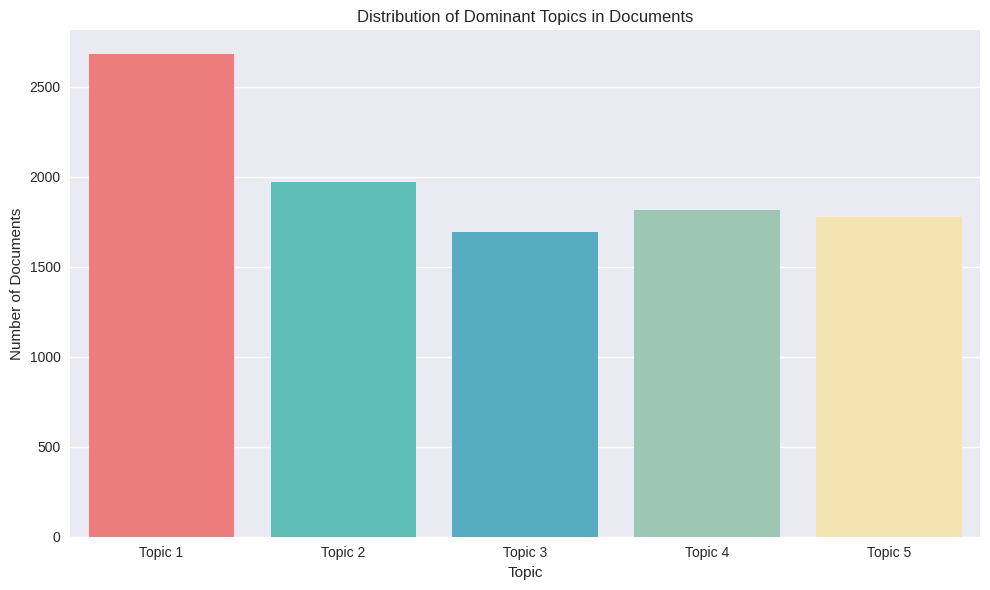

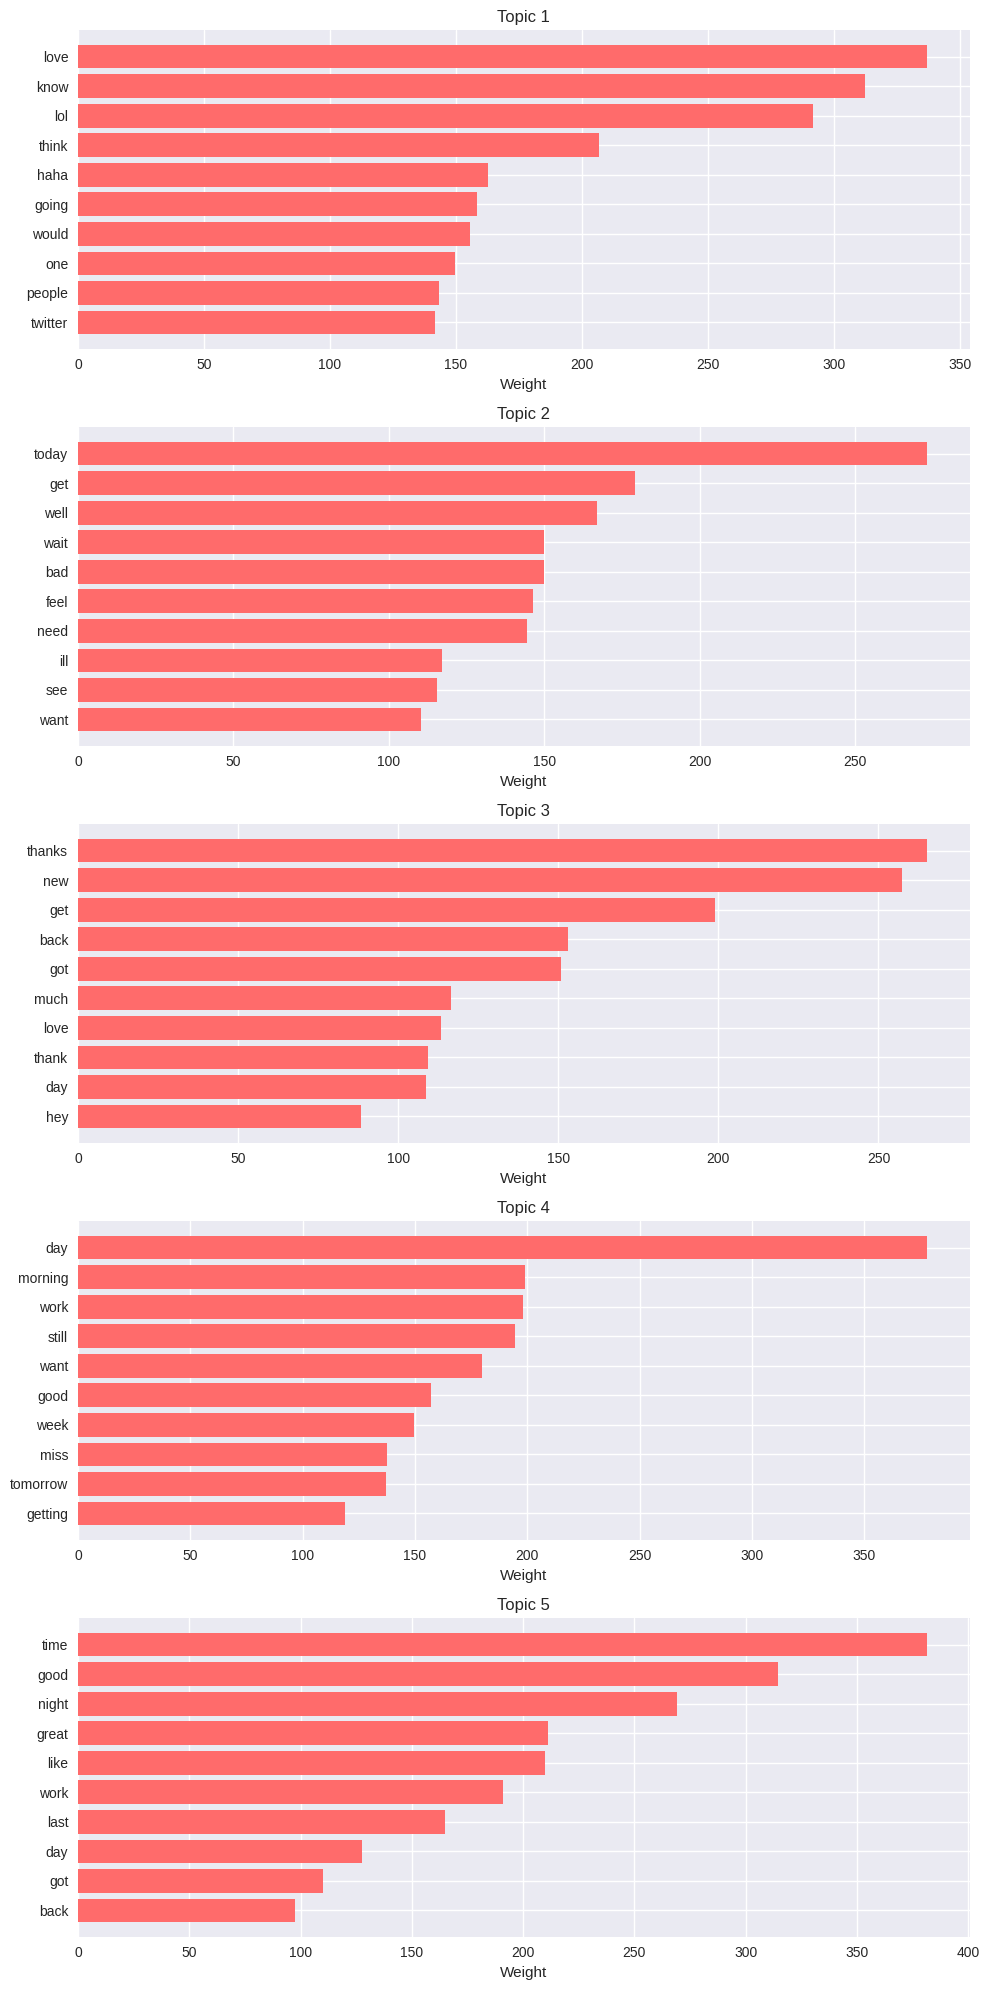

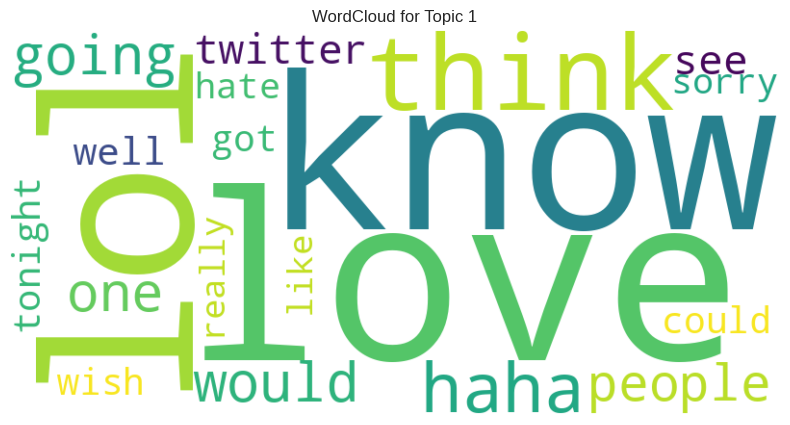

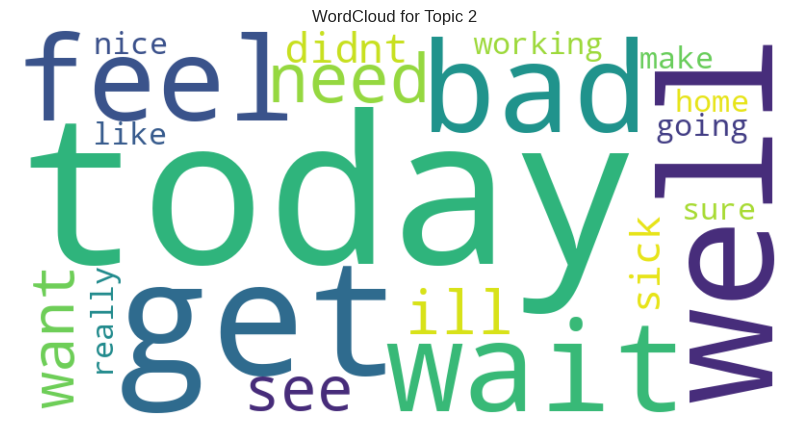

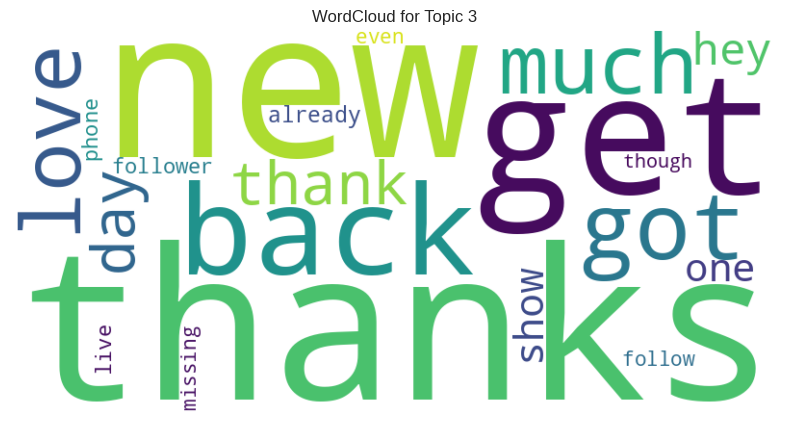

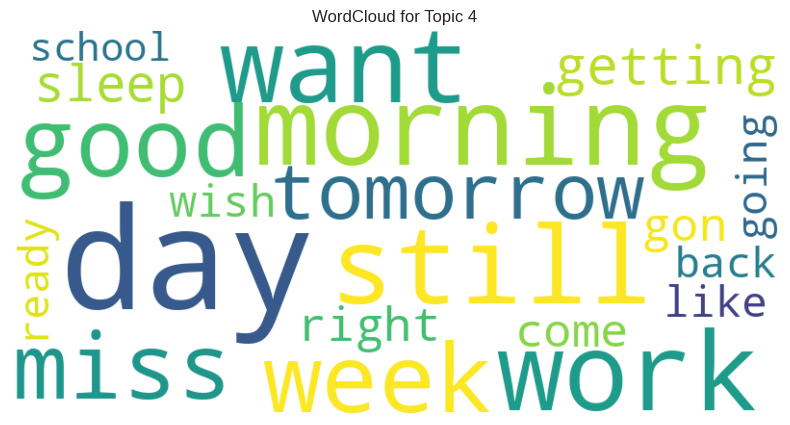

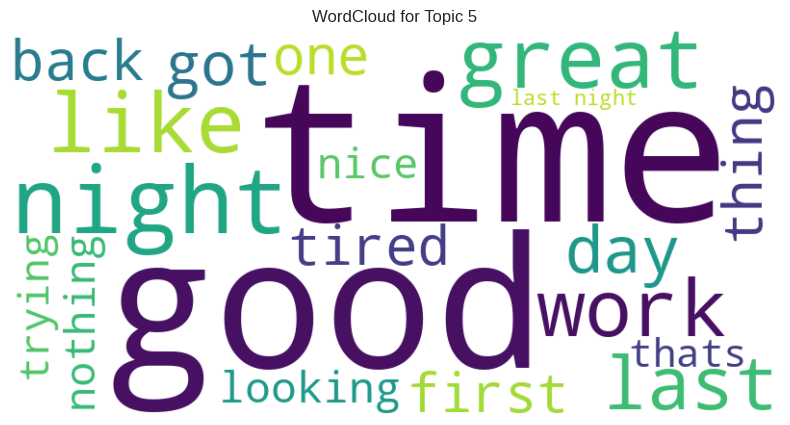

🤖 Training machine learning models...

NAIVE_BAYES Performance:
Accuracy: 0.7230

LOGISTIC_REGRESSION Performance:
Accuracy: 0.7175

RANDOM_FOREST Performance:
Accuracy: 0.6980
📈 Creating visualizations...


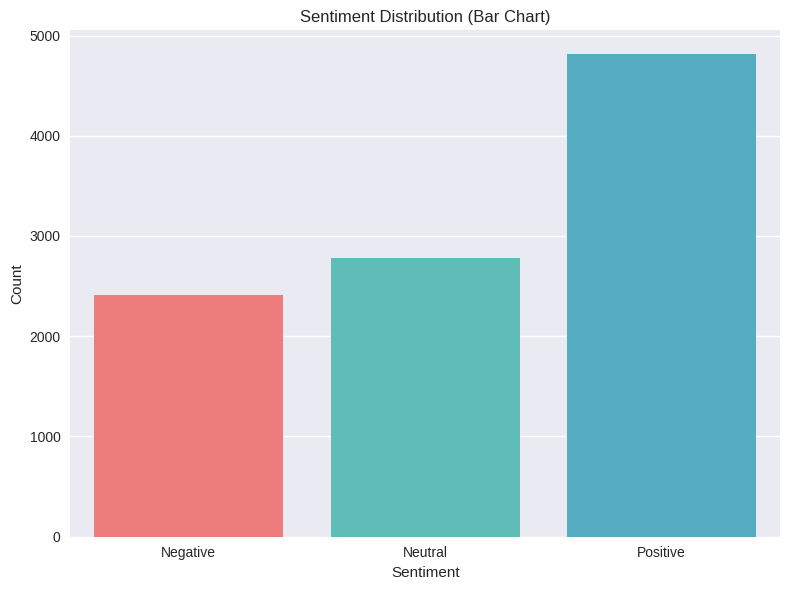

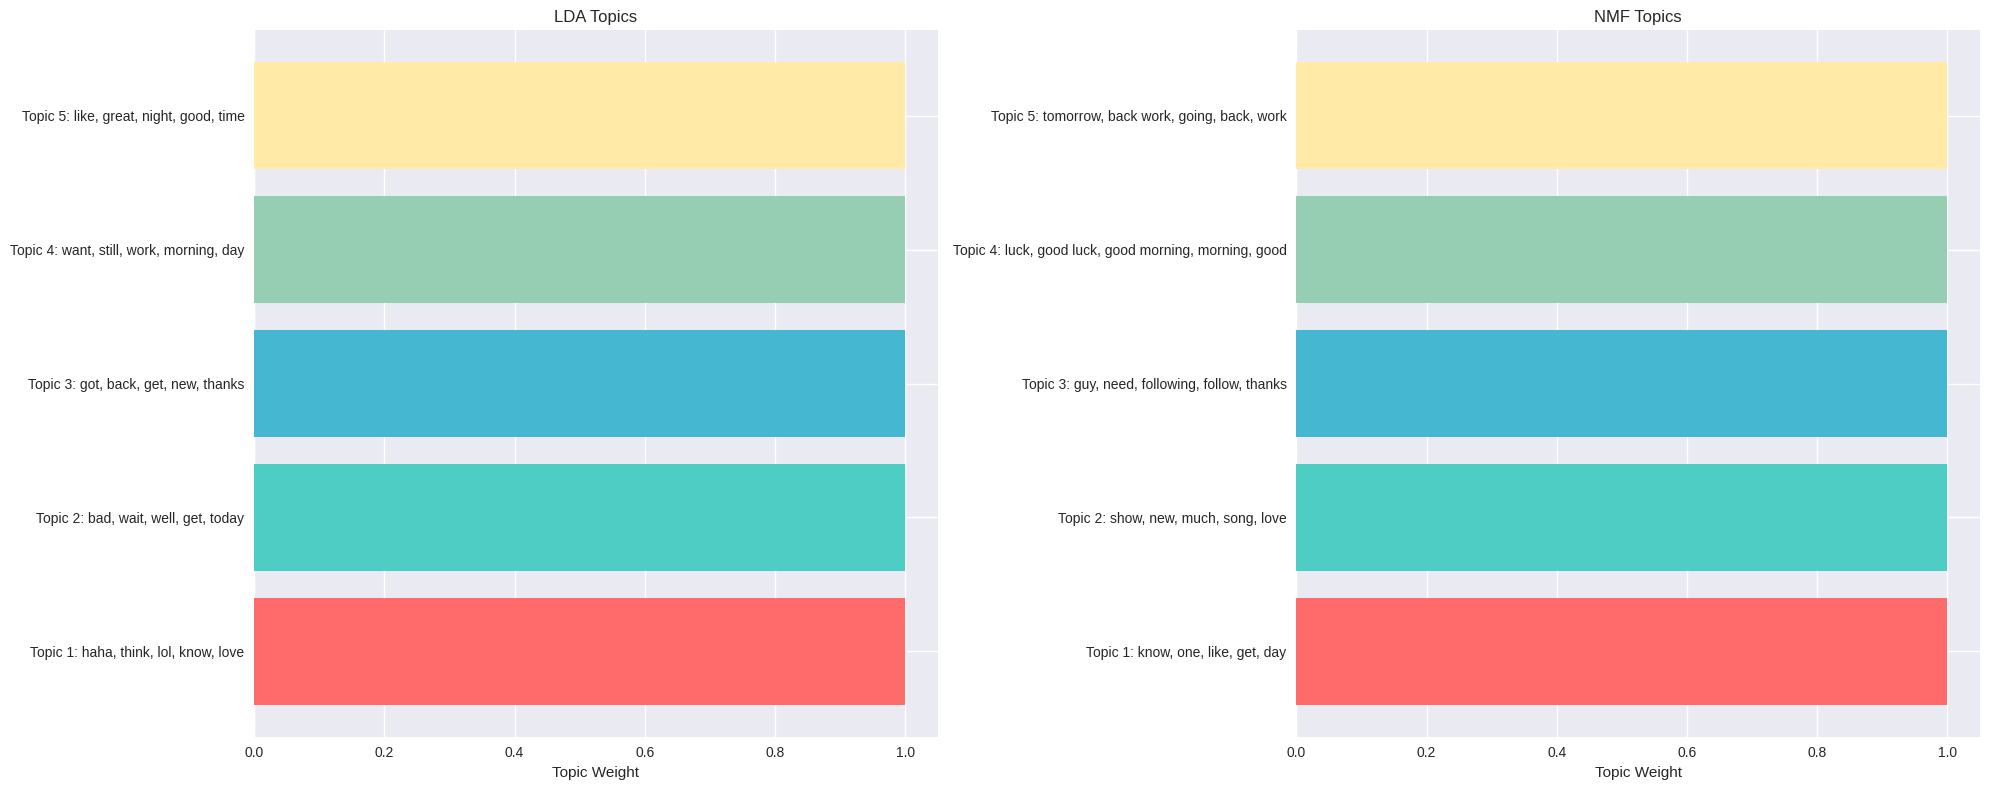

☁️ Generating word clouds...


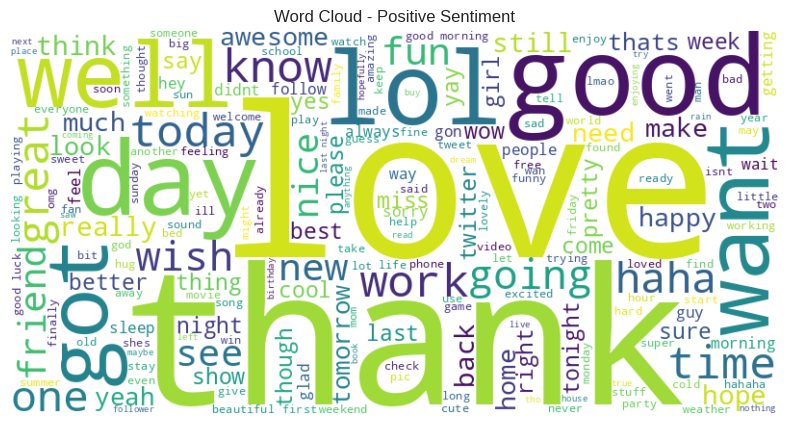

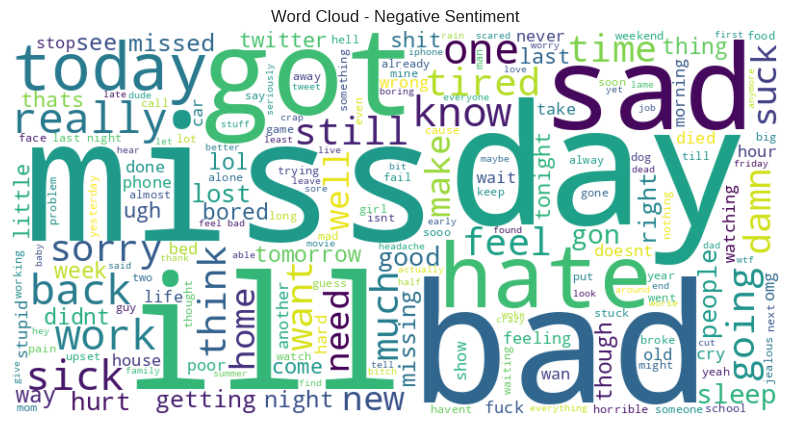

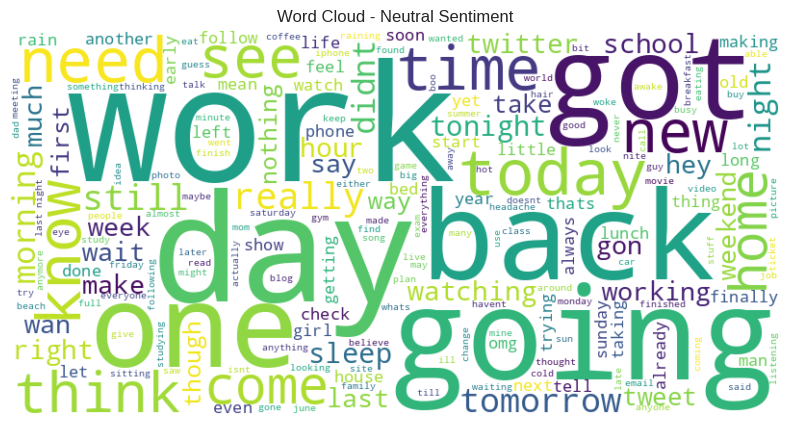

✅ Analysis complete! Results saved to database.

📊 ANALYSIS SUMMARY:
Total tweets analyzed: 10000
Sentiment distribution:
predicted_sentiment
Positive    4811
Neutral     2782
Negative    2407
Name: count, dtype: int64

Top LDA Topics:
Topic 1: haha, think, lol, know, love
Topic 2: bad, wait, well, get, today
Topic 3: got, back, get, new, thanks
Topic 4: want, still, work, morning, day
Topic 5: like, great, night, good, time
🎉 Enhanced Twitter Sentiment Analysis Pipeline Ready!
Usage: df_result, topics_lda, topics_nmf = main_analysis_pipeline('/path/to/dataset.csv')


In [ ]:


# =============================================================================
# 6. MAIN EXECUTION PIPELINE
# =============================================================================

def main_analysis_pipeline(data_path):
    """Main pipeline for comprehensive Twitter sentiment analysis"""

    print("🚀 Starting Comprehensive Twitter Sentiment Analysis Pipeline...")

    # Initialize components
    db_manager = TwitterDataManager()
    preprocessor = TextPreprocessor()
    topic_modeler = TopicModeler(n_topics=5)
    visualizer = AdvancedVisualizer()
    classifier = SentimentClassifier()

    # Load data
    print("📊 Loading data...")
    df = pd.read_csv(data_path, encoding='latin-1')

    # Rename columns (assuming standard Twitter dataset format)
    if len(df.columns) == 6:
        df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

    # Sample data for demonstration (use full dataset in production)
    df_sample = df.sample(n=min(10000, len(df)), random_state=42)

    print("🧹 Preprocessing data...")
    # Preprocess text
    df_sample['cleaned_text'] = df_sample['text'].apply(preprocessor.clean_text)

    # Get sentiment scores
    sentiment_scores = df_sample['cleaned_text'].apply(preprocessor.get_sentiment_scores)
    df_sample['compound_score'] = sentiment_scores.apply(lambda x: x['compound'])
    df_sample['confidence_score'] = sentiment_scores.apply(lambda x: abs(x['compound']))
    df_sample['predicted_sentiment'] = df_sample['compound_score'].apply(preprocessor.classify_sentiment)

    # Add additional features
    df_sample['word_count'] = df_sample['text'].apply(lambda x: len(str(x).split()))
    df_sample['char_count'] = df_sample['text'].apply(len)

    # Process dates
    df_sample['date'] = pd.to_datetime(df_sample['date'], errors='coerce')
    df_sample['hour'] = df_sample['date'].dt.hour

    print("🗄️ Storing data in database...")
    # Prepare data for database
    db_data = df_sample[['id', 'date', 'user', 'text', 'cleaned_text', 'sentiment',
                        'predicted_sentiment', 'confidence_score', 'word_count', 'char_count', 'hour']].copy()
    db_data.columns = ['tweet_id', 'date', 'user', 'original_text', 'cleaned_text', 'sentiment_label',
                      'predicted_sentiment', 'confidence_score', 'word_count', 'char_count', 'hour']

    # Store in database
    db_manager.insert_tweets(db_data)

    print("🎯 Performing topic modeling...")
    # Topic modeling
    clean_texts = df_sample['cleaned_text'].dropna().tolist()
    clean_texts = [text for text in clean_texts if len(text.strip()) > 0]

    if len(clean_texts) > 0:
        topics_lda = topic_modeler.fit_lda(clean_texts)
        topics_nmf = topic_modeler.fit_nmf(clean_texts)
        # Simpan komponen model
        lda_model = topic_modeler.lda_model
        tf_vectorizer = topic_modeler.vectorizer
        doc_topic_matrix = lda_model.transform(tf_vectorizer.transform(clean_texts))

        print("🧠 Visualizing topic modeling results...")
        visualizer.plot_topic_distribution(doc_topic_matrix)
        visualizer.plot_top_words_per_topic(lda_model, tf_vectorizer.get_feature_names_out())
        visualizer.plot_topic_wordclouds(lda_model, tf_vectorizer.get_feature_names_out())


        # Store topics in database
        db_manager.insert_topics(topics_lda, 'LDA')
        db_manager.insert_topics(topics_nmf, 'NMF')

    print("🤖 Training machine learning models...")
    # Train ML models
    valid_texts = df_sample.dropna(subset=['cleaned_text', 'sentiment'])
    if len(valid_texts) > 100:
        ml_results = classifier.train_models(
            valid_texts['cleaned_text'],
            valid_texts['sentiment']
        )

        # Print model performance
        for model_name, results in ml_results.items():
            print(f"\n{model_name.upper()} Performance:")
            print(f"Accuracy: {results['accuracy']:.4f}")

    print("📈 Creating visualizations...")
    # Create visualizations
    visualizer.plot_sentiment_distribution_advanced(df_sample)

    if len(clean_texts) > 0:
        visualizer.plot_topic_modeling_results(topics_lda, topics_nmf)

    # Create word clouds
    print("☁️ Generating word clouds...")
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        sentiment_texts = df_sample[df_sample['predicted_sentiment'] == sentiment]['cleaned_text']
        if len(sentiment_texts) > 0:
            combined_text = ' '.join(sentiment_texts.dropna())
            if len(combined_text) > 0:
                wordcloud = WordCloud(
                    width=800, height=400,
                    background_color='white',
                    colormap='viridis'
                ).generate(combined_text)

                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                plt.title(f'Word Cloud - {sentiment} Sentiment')
                plt.show()

    print("✅ Analysis complete! Results saved to database.")

    # Summary statistics
    print("\n📊 ANALYSIS SUMMARY:")
    print(f"Total tweets analyzed: {len(df_sample)}")
    print(f"Sentiment distribution:")
    print(df_sample['predicted_sentiment'].value_counts())

    if len(clean_texts) > 0:
        print(f"\nTop LDA Topics:")
        for i, topic in enumerate(topics_lda):
            print(f"Topic {i+1}: {', '.join(topic[-5:])}")

    # Close database connection
    db_manager.close()

    return df_sample, topics_lda, topics_nmf

# Example usage:
df_result, topics_lda, topics_nmf = main_analysis_pipeline('/content/gdrive/MyDrive/dataset/x-dataset/dataset.csv')


# misal kamu sudah punya:
# lda_model, tfidf_vectorizer, doc_topic_matrix



print("🎉 Enhanced Twitter Sentiment Analysis Pipeline Ready!")
print("Usage: df_result, topics_lda, topics_nmf = main_analysis_pipeline('/path/to/dataset.csv')")

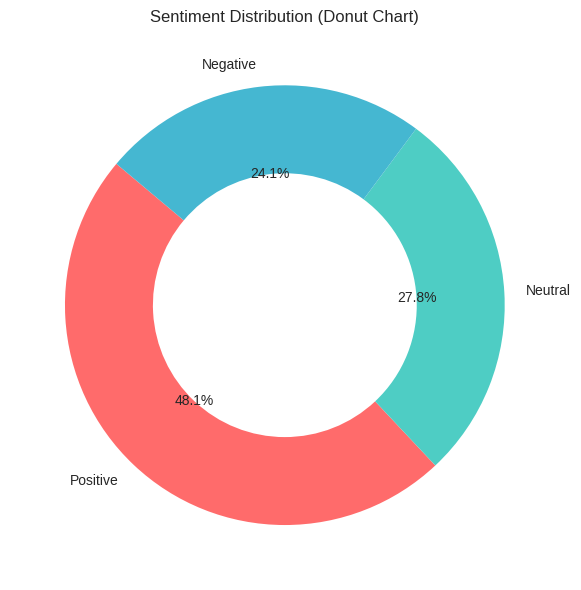

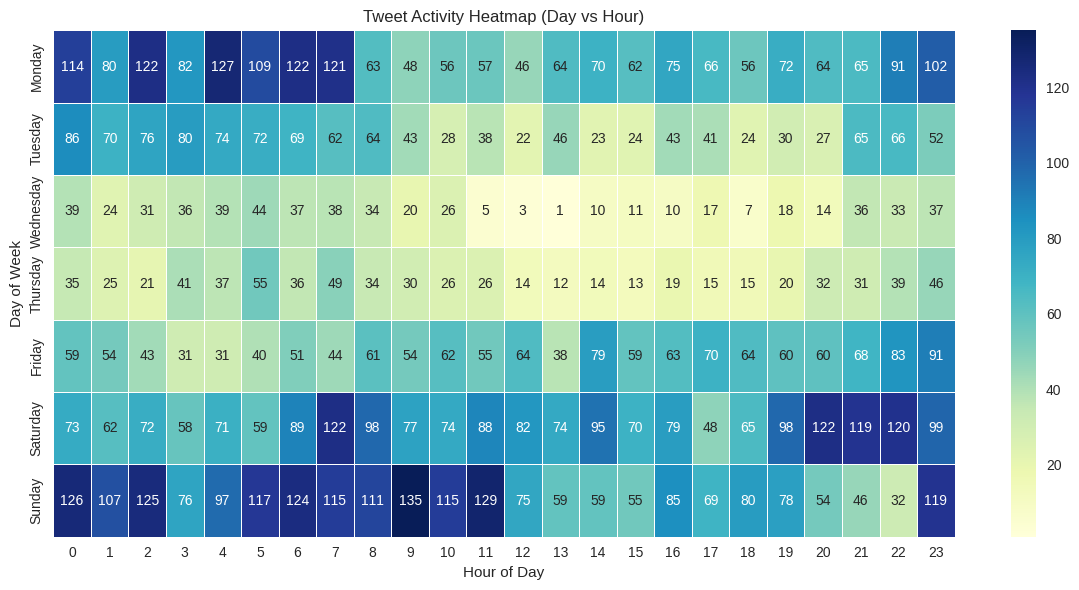

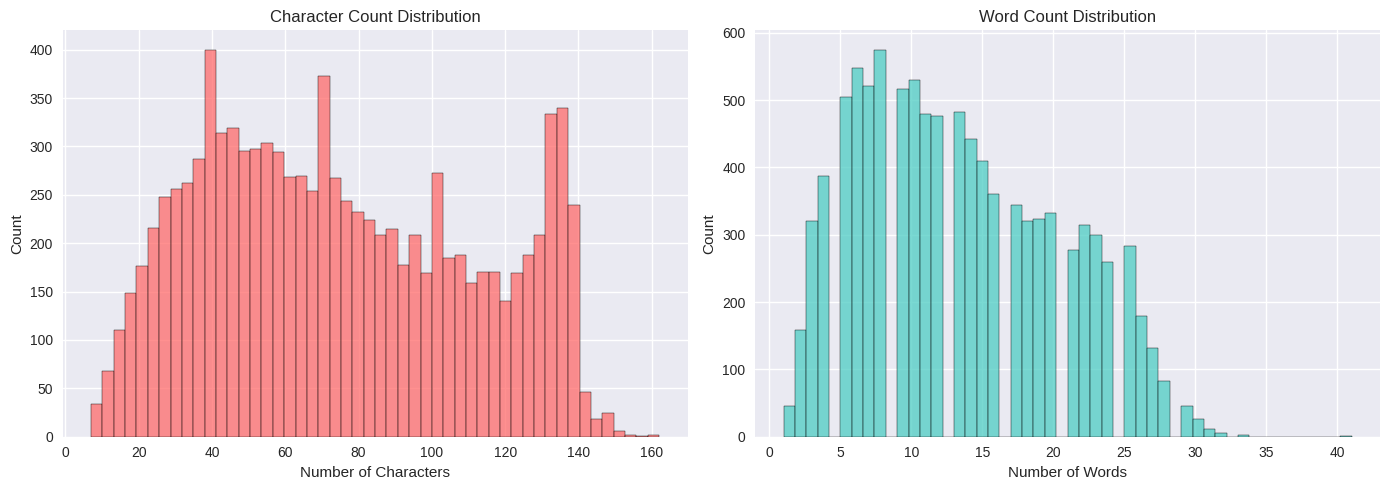

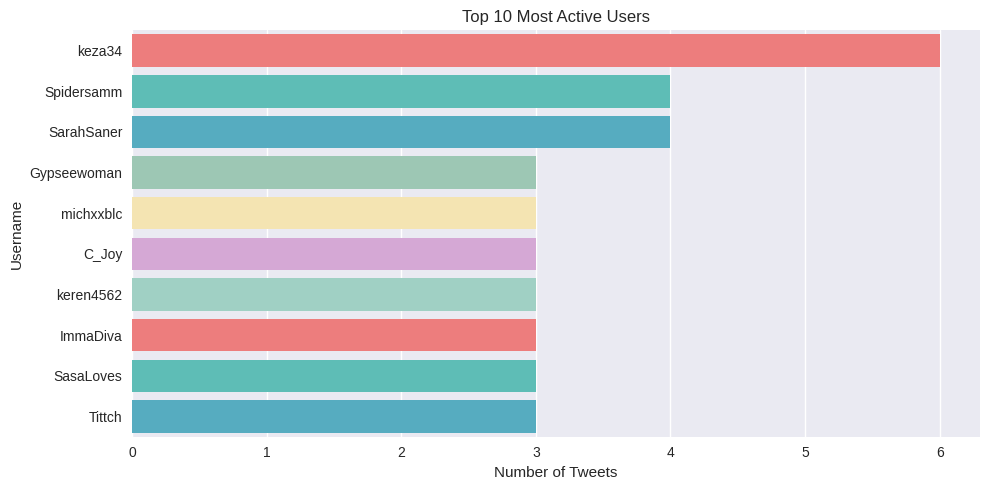

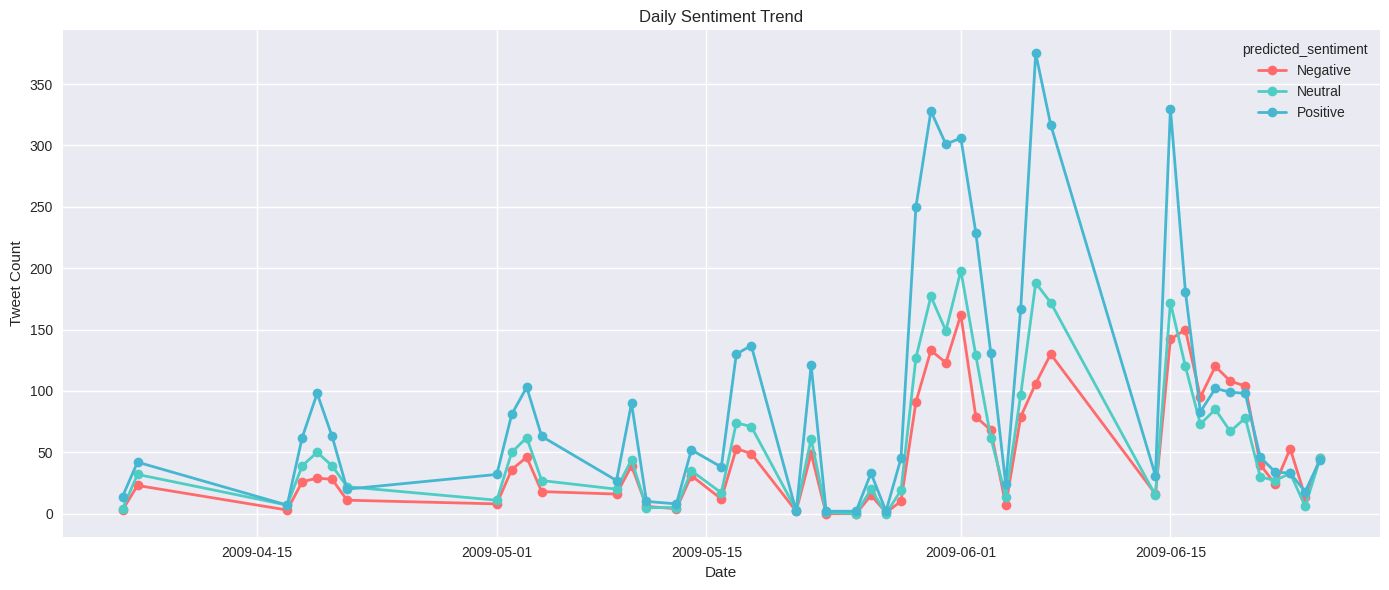

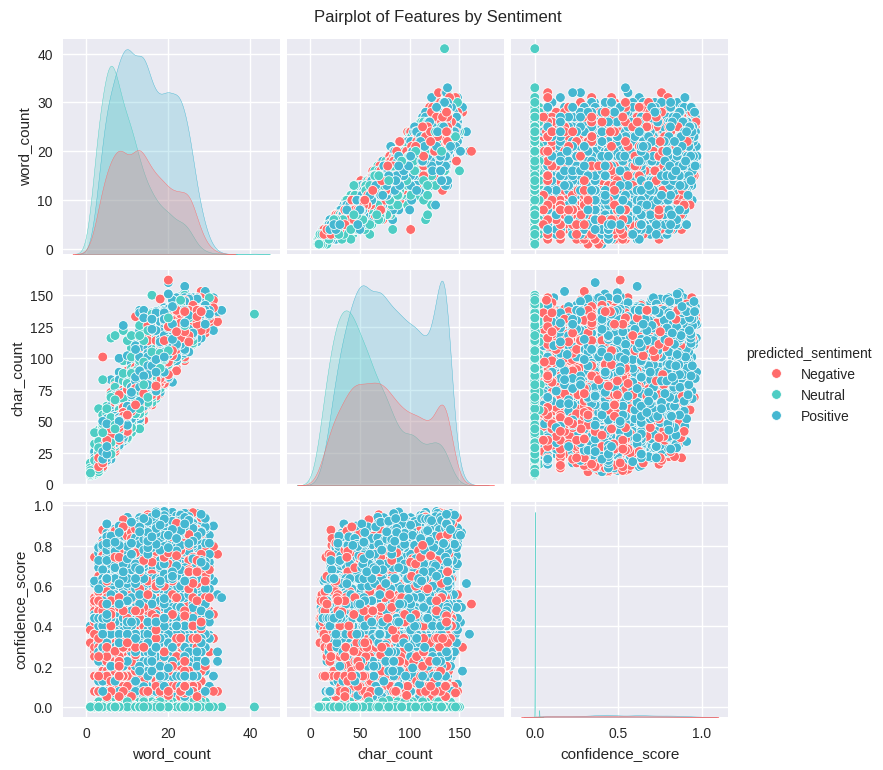

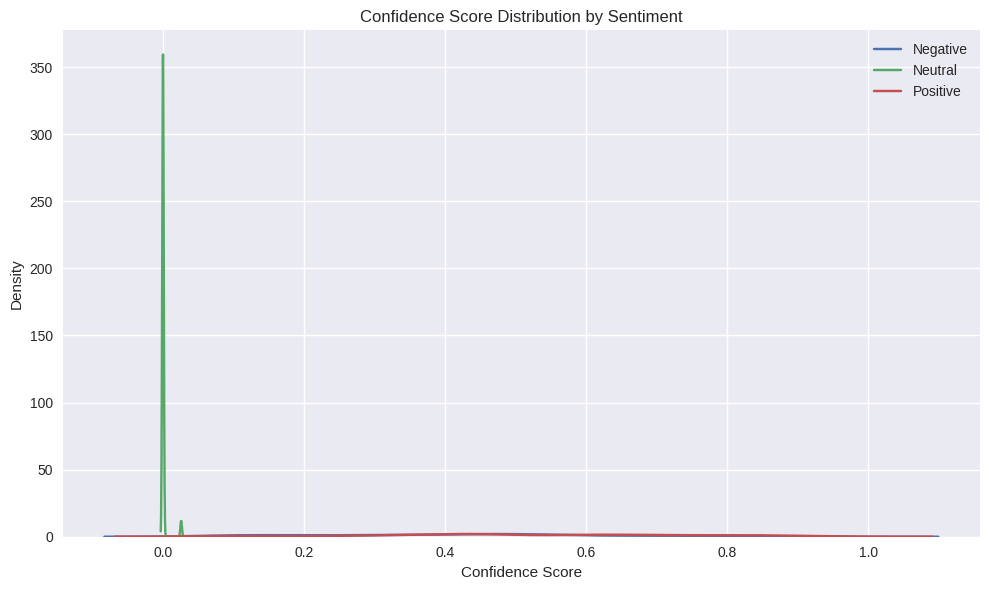

In [ ]:
visualizer = AdvancedVisualizer()
visualizer.plot_sentiment_donut(df_result)
visualizer.plot_activity_heatmap(df_result)
visualizer.plot_length_distribution(df_result)
visualizer.plot_top_users(df_result)
visualizer.plot_daily_sentiment_trend(df_result)
visualizer.plot_pairplot(df_result)
visualizer.plot_confidence_kde(df_result)

In [ ]:
!pip install dash dash-bootstrap-components pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


In [ ]:
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
from pyngrok import ngrok
import pandas as pd
import plotly.express as px


In [ ]:
!pip install dash dash-bootstrap-components pyngrok


In [ ]:
ngrok.kill()

🚀 Starting Comprehensive Twitter Sentiment Analysis Pipeline...
📊 Loading data...
🧹 Preprocessing data...
🗄️ Storing data in database...
🎯 Performing topic modeling...
🧠 Visualizing topic modeling results...


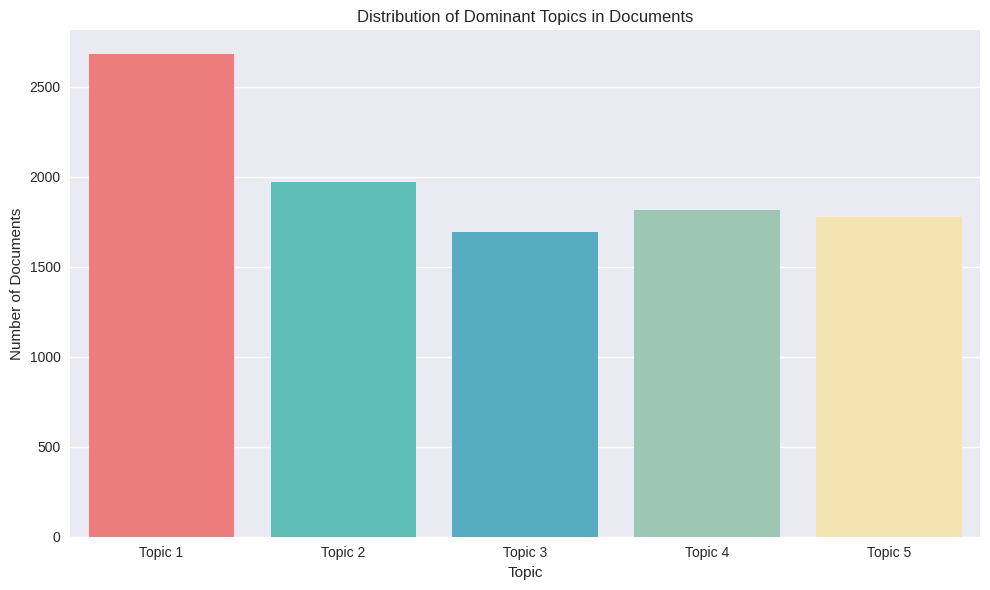

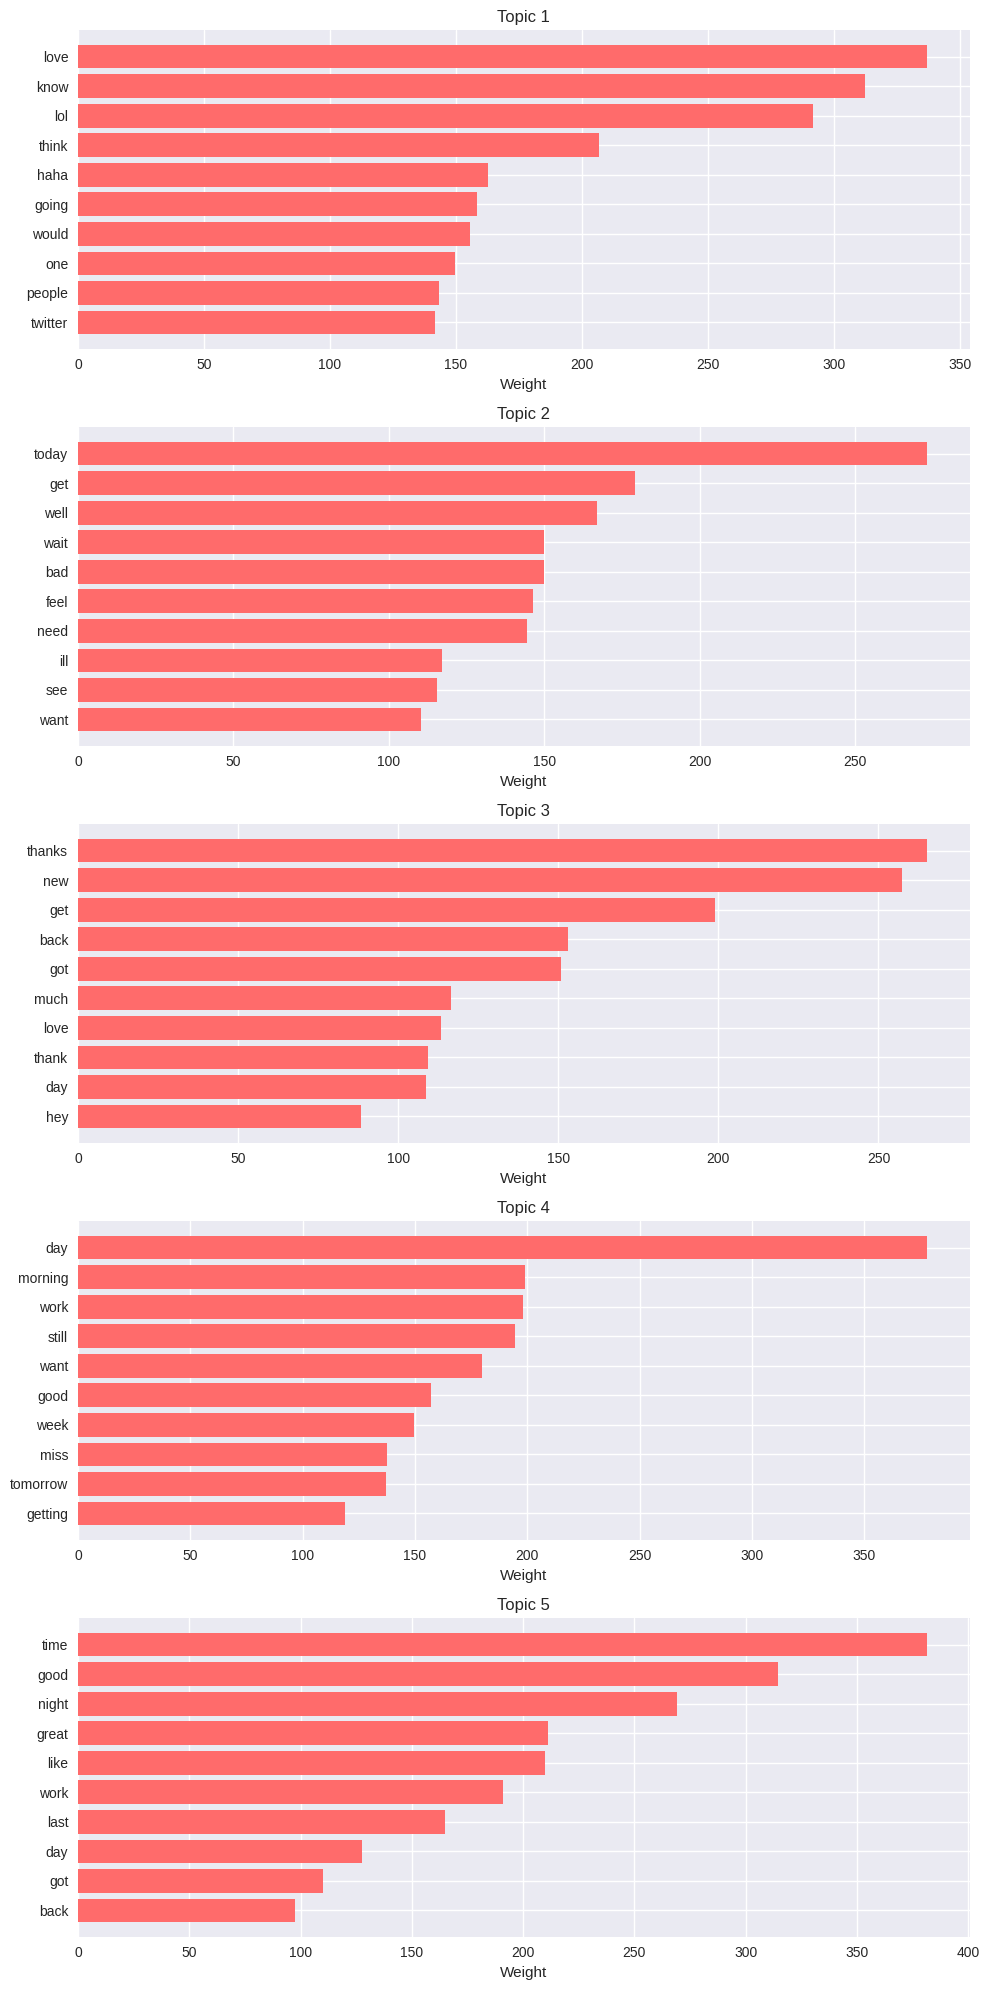

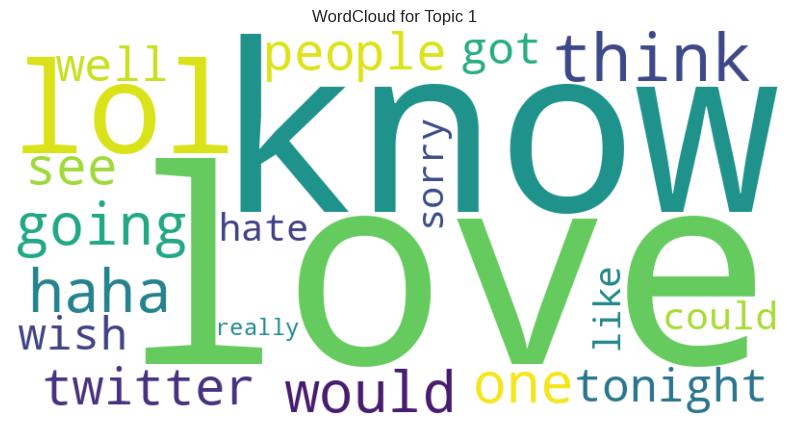

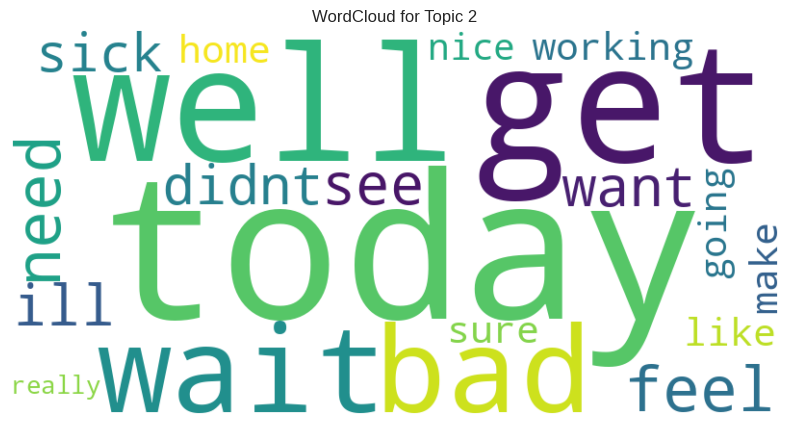

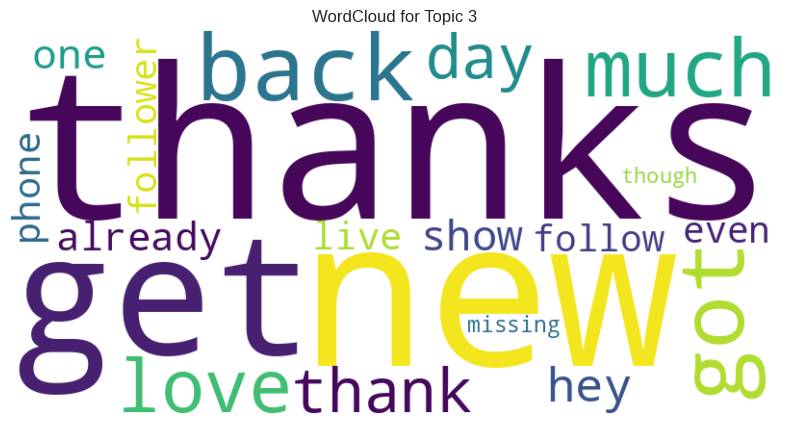

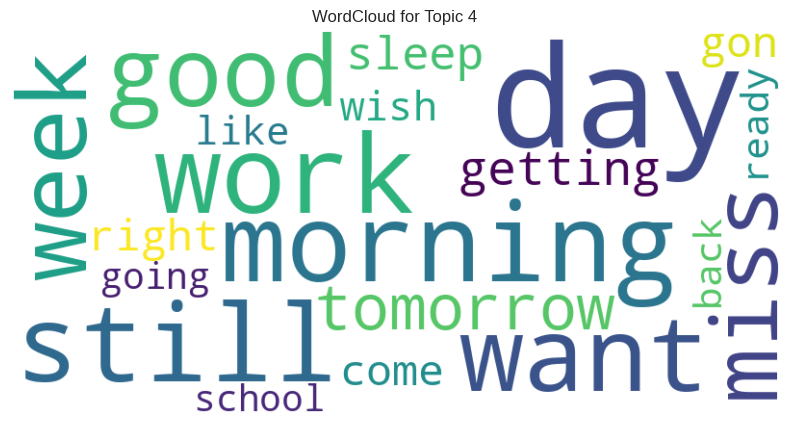

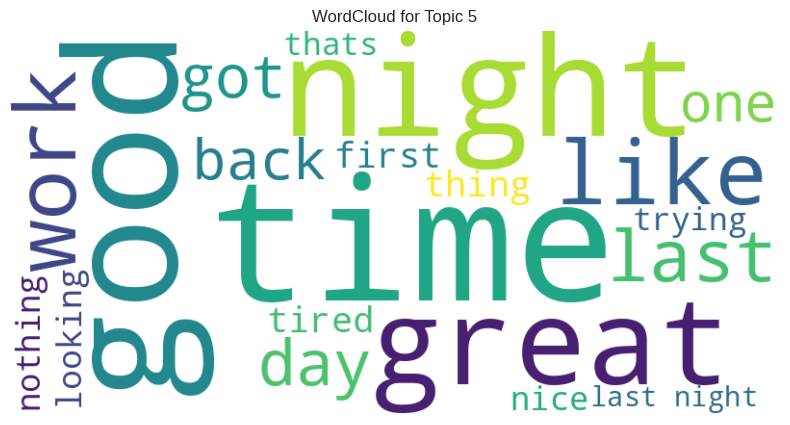

🤖 Training machine learning models...

NAIVE_BAYES Performance:
Accuracy: 0.7230

LOGISTIC_REGRESSION Performance:
Accuracy: 0.7175

RANDOM_FOREST Performance:
Accuracy: 0.6980
📈 Creating visualizations...


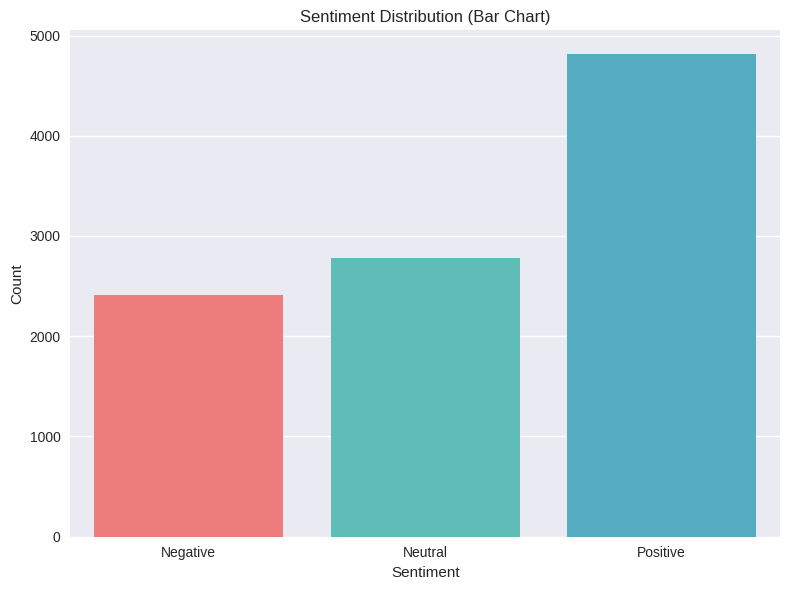

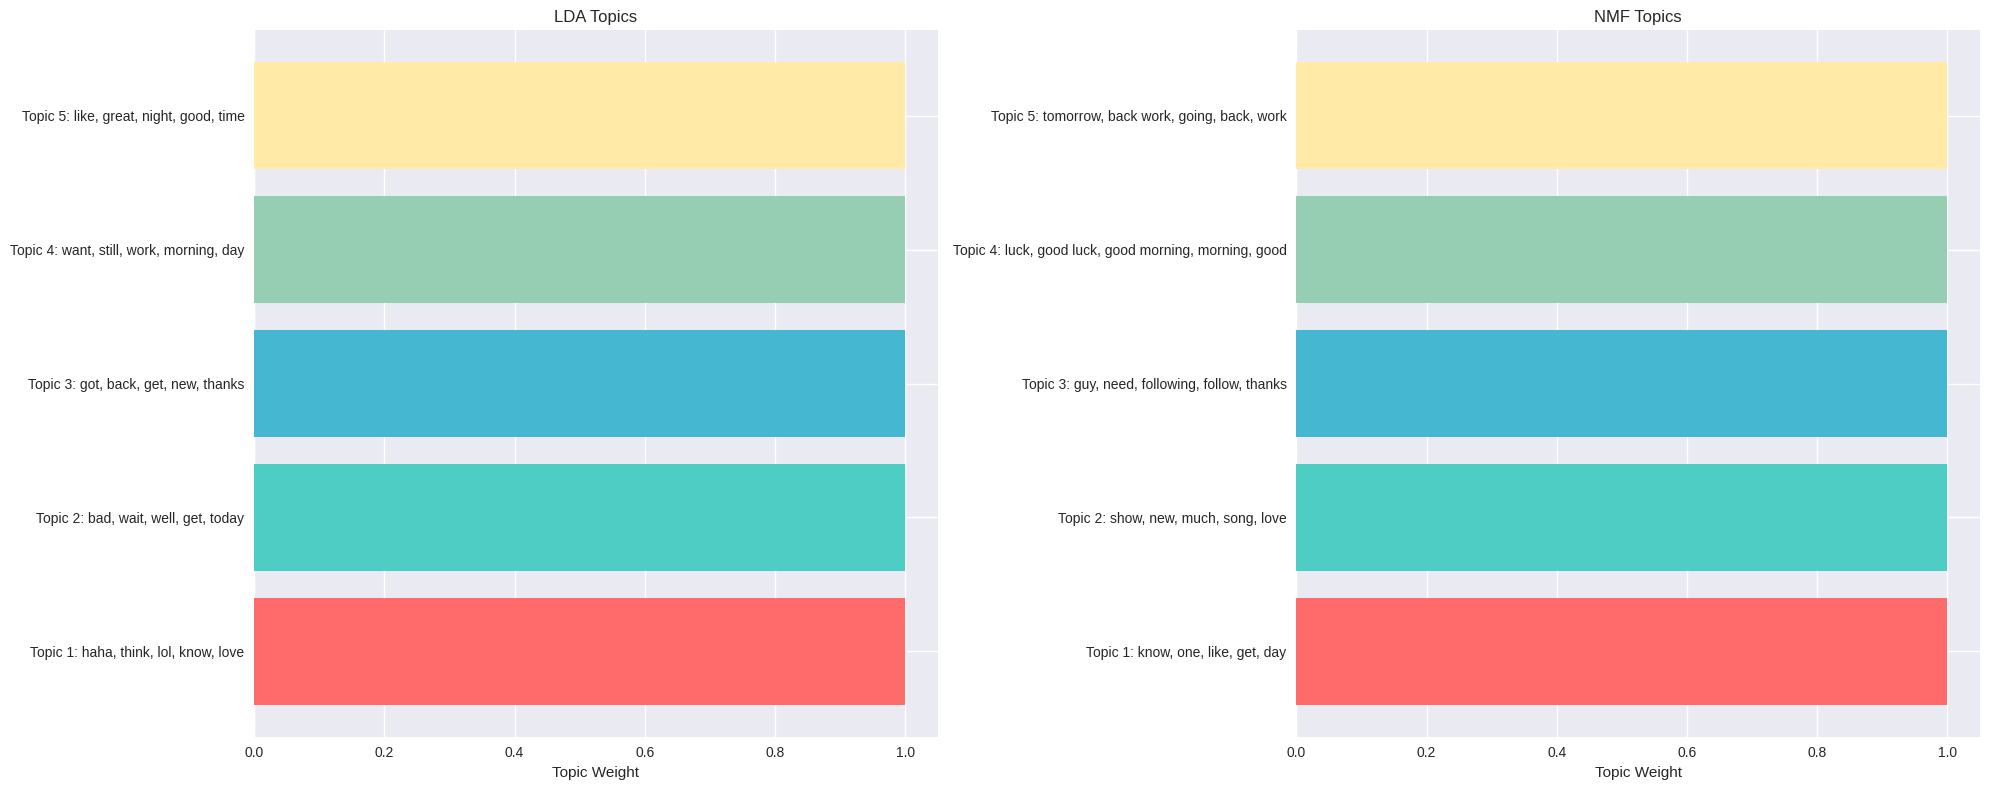

☁️ Generating word clouds...


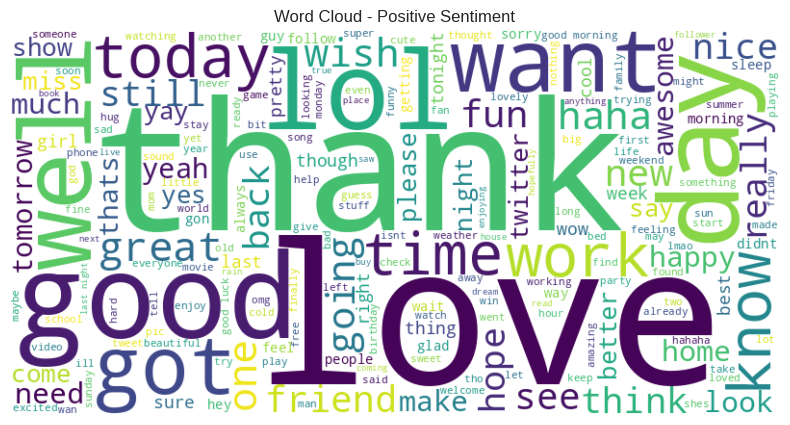

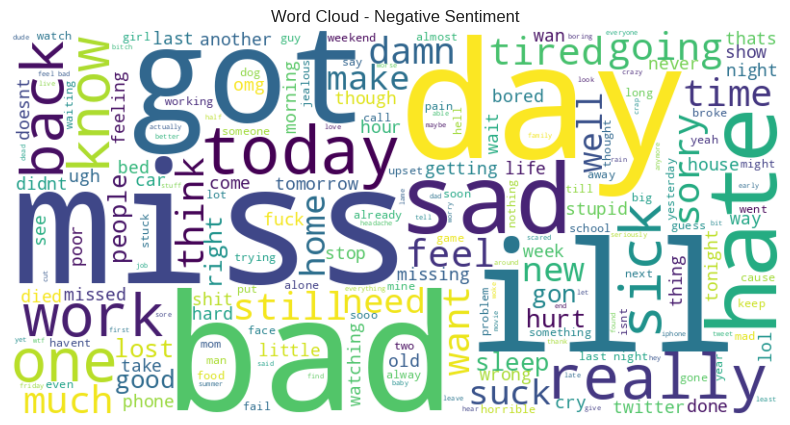

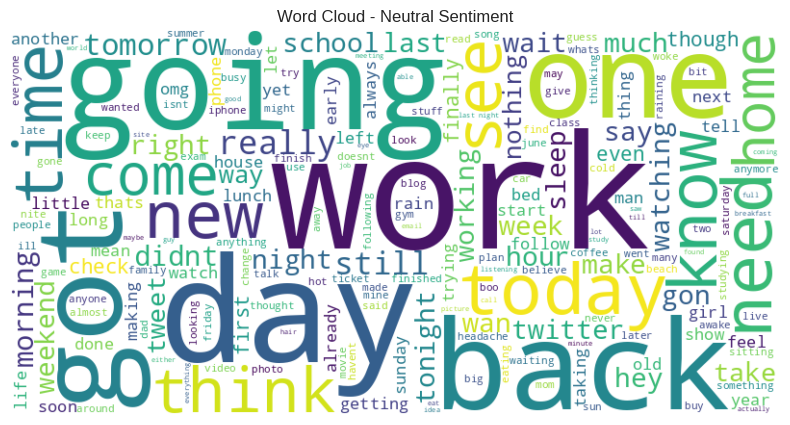

✅ Analysis complete! Results saved to database.

📊 ANALYSIS SUMMARY:
Total tweets analyzed: 10000
Sentiment distribution:
predicted_sentiment
Positive    4811
Neutral     2782
Negative    2407
Name: count, dtype: int64

Top LDA Topics:
Topic 1: haha, think, lol, know, love
Topic 2: bad, wait, well, get, today
Topic 3: got, back, get, new, thanks
Topic 4: want, still, work, morning, day
Topic 5: like, great, night, good, time
🌐 Dashboard tersedia di: NgrokTunnel: "https://1d65-34-106-251-230.ngrok-free.app" -> "http://localhost:8050"


<IPython.core.display.Javascript object>

In [ ]:

from dash import Dash, html, dcc
import dash_bootstrap_components as dbc
import plotly.express as px
from pyngrok import ngrok
import pandas as pd
import numpy as np

# Data dummy
df_result, topics_lda, topics_nmf = main_analysis_pipeline('/content/gdrive/MyDrive/dataset/x-dataset/dataset.csv')

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

sentiment_dist = px.histogram(df_result, x='predicted_sentiment', color='predicted_sentiment')
word_count_box = px.box(df_result, x='predicted_sentiment', y='word_count', color='predicted_sentiment')
char_count_box = px.box(df_result, x='predicted_sentiment', y='char_count', color='predicted_sentiment')
confidence_hist = px.histogram(df_result, x='confidence_score', color='predicted_sentiment', nbins=50)

app.layout = dbc.Container([
    html.H1("📊 Twitter Sentiment Dashboard", className="text-center my-4"),
    dbc.Row([
        dbc.Col(dcc.Graph(figure=sentiment_dist), width=6),
        dbc.Col(dcc.Graph(figure=confidence_hist), width=6),
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(figure=word_count_box), width=6),
        dbc.Col(dcc.Graph(figure=char_count_box), width=6),
    ])
], fluid=True)

ngrok.set_auth_token("2y1r5Zg5HuYpQzfVkVrxxrnTjuI_5UmHTUAMnJSDnkw1MKxCg")
public_url = ngrok.connect(8050)
print(f"🌐 Dashboard tersedia di: {public_url}")

app.run(debug=False, port=8050, use_reloader=False)
